In [1]:
import kinase_library as kl
testsequence='PSVEPPLsQETFSDL'

# Create a Substrate object with a target sequence (example: p53 S33)
s = kl.Substrate(testsequence)  # Lowercase 's' indicates a phosphoserine

# Predict potential kinase interactions for the substrate
s.predict()

Matplotlib is building the font cache; this may take a moment.


,Score,Score Rank,Percentile,Percentile Rank
ATM,5.0385,1,99.83,1
SMG1,4.2377,2,99.77,2
ATR,3.5045,4,99.69,3
DNAPK,3.8172,3,99.21,4
FAM20C,3.1716,5,95.23,5
...,...,...,...,...
BRAF,-4.4003,242,7.86,306
AKT2,-5.6530,284,6.79,307
P70S6KB,-3.9915,223,6.64,308
NEK3,-8.2455,310,4.85,309


In [ ]:
"""Task 1 - to write code mutating first amino acid to every other possible amino acid"""
#how to replace one letter for another in test sequence.

#how to replace one letter for each amino acid



In [2]:
mutated_sequences = [] #creates a list to store the mutated amino acids
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # defines the standard 20 amino acids
for i, original_aa in enumerate(testsequence): #indexes the original amino acids 
    for new_aa in amino_acids: #creates a loop of all amino acids
        if new_aa != original_aa:  # Avoid replacing with itself
                mutated_seq = testsequence[:i] + new_aa + testsequence[i+1:] #creates a new sequence (mutated seq)
                mutated_sequences.append(mutated_seq) #stores mutated sequence

print(f'Mutated sequences (# sequences = {len(mutated_sequences)})')
print(mutated_sequences)
 #shows mutations at each position


        

Mutated sequences (# sequences = 286)
['ASVEPPLsQETFSDL', 'CSVEPPLsQETFSDL', 'DSVEPPLsQETFSDL', 'ESVEPPLsQETFSDL', 'FSVEPPLsQETFSDL', 'GSVEPPLsQETFSDL', 'HSVEPPLsQETFSDL', 'ISVEPPLsQETFSDL', 'KSVEPPLsQETFSDL', 'LSVEPPLsQETFSDL', 'MSVEPPLsQETFSDL', 'NSVEPPLsQETFSDL', 'QSVEPPLsQETFSDL', 'RSVEPPLsQETFSDL', 'SSVEPPLsQETFSDL', 'TSVEPPLsQETFSDL', 'VSVEPPLsQETFSDL', 'WSVEPPLsQETFSDL', 'YSVEPPLsQETFSDL', 'PAVEPPLsQETFSDL', 'PCVEPPLsQETFSDL', 'PDVEPPLsQETFSDL', 'PEVEPPLsQETFSDL', 'PFVEPPLsQETFSDL', 'PGVEPPLsQETFSDL', 'PHVEPPLsQETFSDL', 'PIVEPPLsQETFSDL', 'PKVEPPLsQETFSDL', 'PLVEPPLsQETFSDL', 'PMVEPPLsQETFSDL', 'PNVEPPLsQETFSDL', 'PPVEPPLsQETFSDL', 'PQVEPPLsQETFSDL', 'PRVEPPLsQETFSDL', 'PTVEPPLsQETFSDL', 'PVVEPPLsQETFSDL', 'PWVEPPLsQETFSDL', 'PYVEPPLsQETFSDL', 'PSAEPPLsQETFSDL', 'PSCEPPLsQETFSDL', 'PSDEPPLsQETFSDL', 'PSEEPPLsQETFSDL', 'PSFEPPLsQETFSDL', 'PSGEPPLsQETFSDL', 'PSHEPPLsQETFSDL', 'PSIEPPLsQETFSDL', 'PSKEPPLsQETFSDL', 'PSLEPPLsQETFSDL', 'PSMEPPLsQETFSDL', 'PSNEPPLsQETFSDL', 'PSPEPPLsQE

In [ ]:
'''
Task2 - Run these sequences through the predict function and store the output as a csv file. Look at pandas.to_csv() for this.
Output should be 280 separate csv files. Don't worry about a naming convention yet. 
'''



In [3]:
import kinase_library as kl
import pandas as pd

testsequence = 'PSVEPPLsQETFSDL'  
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
mutated_sequences = []  

for i, original_aa in enumerate(testsequence):  
    for new_aa in amino_acids:
        if new_aa != original_aa:  
                mutated_seq = testsequence[:i] + new_aa + testsequence[i+1:] 
                mutated_sequences.append((i, original_aa, new_aa, mutated_seq))  


print(f"Total mutations generated: {len(mutated_sequences)}") 

for i, original_aa, new_aa, mutated_seq in mutated_sequences: #below is gpt code, wanted to see what exceptions it threw up using try function
    try:
        s = kl.Substrate(mutated_seq)
        predictions = s.predict()


        df = pd.DataFrame(predictions)

        # Save to CSV file with a structured name
        filename = f"mutation_Pos{i}_{original_aa}_to_{new_aa}.csv"
        df.to_csv(filename, index=False)

    except Exception as e:
        print(f"Skipping mutation at position {i} ({original_aa} → {new_aa}): {e}")





Total mutations generated: 286
Skipping mutation at position 7 (s → A): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → C): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → D): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → E): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → F): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (s → G): Central residue must be a phosphoacceptor (s/t/y). Otherwise, please identify the position of the phosphoacceptor.
Skipping mutation at position 7 (

In [4]:
import os
import pandas as pd

# Directory containing mutation CSVs
mut_predictions = "C:/Users/ricea/OneDrive/Documents/GitHub/Annabel-BSc-Project"

# Find a sample mutation file to use as a template
sample_file = None
for file in os.listdir(mut_predictions):
    if file.endswith(".csv"):
        sample_file = os.path.join(mut_predictions, file)
        break  # Stop after finding the first valid file

if not sample_file:
    raise ValueError("No mutation CSV files found!")

# Read sample file
df = pd.read_csv(sample_file)

# Ensure "Score Rank" exists
if "Score Rank" not in df.columns:
    raise ValueError(f"'Score Rank' column not found in {sample_file}")

# Create a wild-type CSV using the same structure
df_wildtype = df.copy()
df_wildtype["Mutation"] = "Wild-Type"  # Mark as wild-type

# Save the new wild-type CSV
wildtype_path = os.path.join(mut_predictions, "wildtype.csv")
df_wildtype.to_csv(wildtype_path, index=False)

print(f"Wild-type CSV created: {wildtype_path}")


Wild-type CSV created: C:/Users/ricea/OneDrive/Documents/GitHub/Annabel-BSc-Project\wildtype.csv


In [ ]:
'''
Task3 - Run through the 286 csv files and extract the order of the kinases. Then using the test sequence as the reference.
Compute a metric for each pair using something similar to LCS (link for inspo attached - https://chatgpt.com/share/67c705a9-9c74-8001-a8da-eac57f06384f)  
'''

In [ ]:
import os
import pandas as pd
from difflib import SequenceMatcher

#This extracts the kinase orders from 269 files - one being the reference sequence.
#I assume some mutations at position 7 are skipped due to the lack of phosphoacceptor.
#So giving 18 fewer LCS scores compared to the number of CSV files generated earlier.
#This is consistent with the data shown on the heatmap in the next cell.

mut_predictions = "C:/Users/ricea/OneDrive/Documents/GitHub/Annabel-BSc-Project"

wildtype_path = os.path.join(mut_predictions, "wildtype.csv")

df_wildtype = pd.read_csv(wildtype_path)

wildtype_kinase_order = df_wildtype["Score Rank"].tolist()  #extracts kinase orders from the reference sequence

kinase_orders = {}

#reads all files to extract the kinase orders (except wildtype as that's already been done)
for file in os.listdir(mut_predictions):
    if file.endswith(".csv") and file != "wildtype.csv":
        file_path = os.path.join(mut_predictions, file)
        try:
            df = pd.read_csv(file_path)
            
            if "Score Rank" in df.columns:
                kinase_orders[file] = df["Score Rank"].tolist()  # Store kinase order
            else:
                print(f"Skipping {file}: No 'Score Rank' column found.") 
        
        except Exception as e:
            print(f"Error reading {file}: {e}")   #debugging steps

print(f"Extracted kinase orders from {len(kinase_orders)} mutation CSVs.") 

# Function to compute Longest Common Subsequence (LCS)
def longest_common_subsequence(seq1, seq2):
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

#finds the LCS between wildtype and mut seqs
lcs_scores = {}
for file, order in kinase_orders.items():
    lcs_length = longest_common_subsequence(order, wildtype_kinase_order)
    lcs_scores[file] = lcs_length

#normalizes LCS scores between 0 and 1
if lcs_scores:
    lcs_min = min(lcs_scores.values())
    lcs_max = max(lcs_scores.values())

    normalized_lcs = {file: (score - lcs_min) / (lcs_max - lcs_min) for file, score in lcs_scores.items()}

   
    df_lcs = pd.DataFrame(list(normalized_lcs.items()), columns=['Mutation_File', 'Normalized_LCS'])
    
    print("\nNormalized LCS Scores:")
    print(df_lcs.sort_values(by="Normalized_LCS", ascending=True))  # Sort by lowest LCS

else:
    print("No LCS scores calculated. Ensure kinase_orders contains data.")


Extracted kinase orders from 269 mutation CSVs.

Normalized LCS Scores:
                 Mutation_File  Normalized_LCS
146   mutation_Pos2_V_to_Q.csv        0.000000
230   mutation_Pos7_s_to_Y.csv        0.006623
139   mutation_Pos2_V_to_H.csv        0.009934
263   mutation_Pos9_E_to_R.csv        0.009934
182   mutation_Pos4_P_to_N.csv        0.009934
..                         ...             ...
101  mutation_Pos14_L_to_H.csv        1.000000
102  mutation_Pos14_L_to_I.csv        1.000000
103  mutation_Pos14_L_to_K.csv        1.000000
16    mutation_Pos0_P_to_V.csv        1.000000
0     mutation_Pos0_P_to_A.csv        1.000000

[269 rows x 2 columns]


In [ ]:
'''
Task 4: generate heatmaps of LCS ratio for each mutation on the y axis and position on the x axis. I like plotly heatmaps for this
https://plotly.com/python/heatmaps/. So output will be a heat map showing hotspots for the mutations that disrup the phosphorylation motif the most
'''

In [9]:
import os
import pandas as pd
import re
import plotly.express as px
import numpy as np

lcs_data = []

for file, normalized_score in normalized_lcs.items():
    
    match = re.match(r"mutation_Pos(\d+)_\w+_to_(\w+)\.csv", file)

    if match:
        position = int(match.group(1)) 
        mutated_aa = match.group(2)  

        lcs_data.append([position, mutated_aa, normalized_score])


df_lcs = pd.DataFrame(lcs_data, columns=['Position', 'Mutation', 'LCS_Ratio'])


heatmap_matrix = df_lcs.pivot_table(index='Mutation', columns='Position', values='LCS_Ratio')


fig = px.imshow(
    heatmap_matrix,
    labels={'x': 'Mutation Position', 'y': 'Mutated Amino Acid', 'color': 'LCS Ratio'},
    color_continuous_scale='Temps',
    title="Heatmap of LCS Ratios for Each Mutation",
)

# Format axes
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        dtick=1  # Show every position
    ),
    coloraxis_colorbar=dict(
        tickvals=[0, 0.25, 0.5, 0.75, 1],  # Set scale from 0 to 1
        ticktext=["0.0", "0.25", "0.5", "0.75", "1.0"]
    )
)


fig.show()







In [ ]:
"Generate tables and subplots showing cases for high and low LCS"

Extracted kinase orders from 270 CSV files.


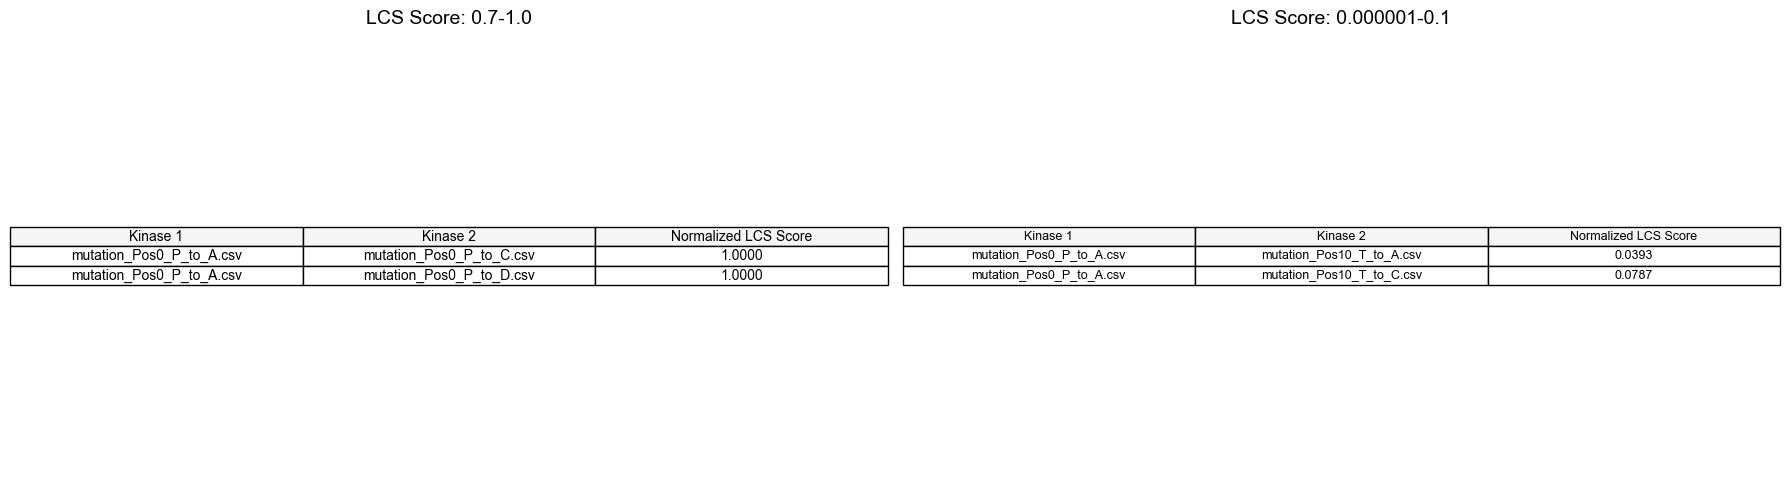

In [ ]:
import os
import pandas as pd
import itertools
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

# Define paths and variables
mut_predictions = "C:/Users/ricea/OneDrive/Documents/GitHub/Annabel-BSc-Project"
kinase_orders = {}

def extract_kinase_orders():
    """Reads CSV files and extracts kinase orders."""
    global kinase_orders
    for file in os.listdir(mut_predictions):  # Finds the CSVs, reads the CSVs
        if file.endswith(".csv"):
            file_path = os.path.join(mut_predictions, file)
            try:
                df = pd.read_csv(file_path)

                # Check if "Score Rank" column exists
                if "Score Rank" in df.columns:
                    kinase_list = df["Score Rank"].tolist()
                    kinase_orders[file] = kinase_list  # Store kinase order for each mutation
                else:
                    print(f"Skipping {file}: No 'Score Rank' column found.")  # Proofreads

            except Exception as e:
                print(f"Error reading {file}: {e}")  # Proofreads

    print(f"Extracted kinase orders from {len(kinase_orders)} CSV files.")  # Checks if it's done

def longest_common_subsequence(seq1, seq2):
    """Computes the Longest Common Subsequence (LCS) length between two lists."""
    matcher = SequenceMatcher(None, seq1, seq2)
    return sum(block.size for block in matcher.get_matching_blocks())

def calculate_lcs_scores():
    """Calculates the pairwise LCS scores between kinase orders."""
    pairwise_lcs = {}
    for (file1, order1), (file2, order2) in itertools.combinations(kinase_orders.items(), 2):
        lcs_length = longest_common_subsequence(order1, order2)
        pairwise_lcs[(file1, file2)] = lcs_length

    lcs_scores = list(pairwise_lcs.values())
    lcs_min = min(lcs_scores)
    lcs_max = max(lcs_scores)

    # Prevent division by zero if all scores are the same
    if lcs_max - lcs_min == 0:
        print("All LCS scores are identical. Normalization skipped.")
        normalized_lcs = {pair: 1.0 for pair in pairwise_lcs}  # Assign all a score of 1
    else:
        normalized_lcs = {pair: (score - lcs_min) / (lcs_max - lcs_min) for pair, score in pairwise_lcs.items()}

    return normalized_lcs

def display_lcs_tables(normalized_lcs):
    """Displays side-by-side tables for LCS scores in specific ranges."""
   
    lcs_groups = {
        '0.7-1.0': [],
        '0.000001-0.1': []
    }

    # Group the data by the LCS score ranges
    for (pair, normalized_score) in normalized_lcs.items():
        if 0.7 <= normalized_score <= 1.0:
            lcs_groups['0.7-1.0'].append((pair, normalized_score))
        elif 0.000001 <= normalized_score <= 0.1:
            lcs_groups['0.000001-0.1'].append((pair, normalized_score))

    # Create side-by-side tables for each LCS group
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    for idx, (score_group, ax) in enumerate(zip(['0.7-1.0', '0.000001-0.1'], axes)):
        data = lcs_groups[score_group][:2]
        
        # Only create a table if there is data
        if data:
            table_data = [(pair[0], pair[1], f"{score:.4f}") for pair, score in data]

            # Create a table
            table = ax.table(cellText=table_data,
                            colLabels=["Kinase 1", "Kinase 2", "Normalized LCS Score"],
                            loc="center",
                            cellLoc="center",
                            colColours=["#f5f5f5"] * 3)

            ax.axis("off")
            ax.set_title(f"LCS Score: {score_group}", fontsize=14)
        else:
            ax.text(0.5, 0.5, f"No data for LCS = {score_group}",
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=12, color='red')

    plt.tight_layout()
    plt.show()

# Example of using the functions:
# Run this once to extract kinase orders and calculate LCS scores
extract_kinase_orders()
normalized_lcs = calculate_lcs_scores()

# Then you can run the display function whenever you want to show the tables
display_lcs_tables(normalized_lcs)
